In [10]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from os.path import join, basename,exists
from glob import glob
from tqdm import tqdm

from obspy import read
from scipy.signal import correlate, correlation_lags, butter, filtfilt, spectrogram
from numpy.fft import fft, fftfreq, ifft, fftshift

ac_calib = 8.2928e-05

in_dir = '/home/zacharykeskinen/data/infrasound/infrasound/processed' #infrasound/banner/infrasound/processed/'
in_dir = '../../data/banner/infrasound/processed'
exists(in_dir)

# l = os.listdir(in_dir)
l = glob(os.path.join(in_dir, 'c0be4*'))
r = []
for i in l:
    i = os.path.basename(i)
    j = i[5:11]
    if j not in r:
        r.append(j)
r.sort()

In [11]:
def freq_filt(arr, order, fc, kind, sps = 200):
    b, a = butter(order, fc, kind, fs = sps)

    return filtfilt(b, a, arr)

In [12]:
def high_pass_filter(arr, order, fc, sps = 200, kind = 'high'):
    b, a = butter(order, fc, kind, fs = sps)

    return filtfilt(b, a, arr)

In [13]:
name_dic = {'be4':'lower','a3m':'upper','ad8':'failed array'}
height_dic = {'lower-p0':0.33,'lower-p1':0.66,'lower-p2':1,'upper-p0':1.33,'upper-p1':np.nan,'upper-p2':2}
full_res = {}

In [14]:
def get_day(day_list, eq_day):
    day = [day for day in day_list if day == eq_day][0]
    res = {}
    ls = glob(join(in_dir, '*'+day+'*'))
    for file in ls:
                name = name_dic[basename(file).replace(day,'')[2:5]]
                if name != 'failed array':
                    tr = read(file)[0]
                    stats = tr.stats
                    sps = stats['sampling_rate']
                    start = stats['starttime']
                    end = stats['endtime']
                    channel = stats['channel']
                    name_channel = f'{name}-{channel}'
                    height = height_dic[name_channel]
                    if not np.isnan(height):
                        arr = tr.data
                        arr = arr * ac_calib
                        arr = arr - np.nanmean(arr)

                        arr_filt = high_pass_filter(arr, 2, 1/10)
                        res[height] = arr_filt
    return res

In [17]:
res = get_day(r, eq_day = '220110')

In [24]:
for i, day in tqdm(enumerate(r), desc = 'days'):
    if day == '220111':
        ls = glob(join(in_dir, '*'+day+'*'))
        res = {}
        for file in ls:
                name = name_dic[basename(file).replace(day,'')[2:5]]
                if name != 'failed array':
                    tr = read(file)[0]
                    stats = tr.stats
                    sps = stats['sampling_rate']
                    start = stats['starttime']
                    end = stats['endtime']
                    channel = stats['channel']
                    name_channel = f'{name}-{channel}'
                    height = height_dic[name_channel]
                    if not np.isnan(height):
                        arr = tr.data
                        arr = arr * ac_calib
                        arr = arr - np.nanmean(arr)

                        arr_filt = high_pass_filter(arr, 2, 1/10)
                        res[height] = arr_filt
        
        full_res[day] = res

days: 104it [00:01, 59.29it/s]


In [19]:
def plot_helioquarter(data_dict, height, date):
    hour_samps = int(data_dict[height].shape[0]/24)
    res_hourly = data_dict[height].reshape(24, hour_samps)
    f, axes = plt.subplots(24, figsize = (30, 10))
    t = np.linspace(0, 60, res_hourly.shape[1])
    for hour in range(res_hourly.shape[0]):
        ax = axes[hour]
        ax.plot(t, res_hourly[hour, :])
        ax.set_ylim(-2.5, 2.5)
        ax.get_yaxis().set_visible(False)
        if hour == 23:
            ax.set_xlabel('Minutes')
        if hour == 0:
            ax.set_title(f'{date} Helioquarter at {height} m')

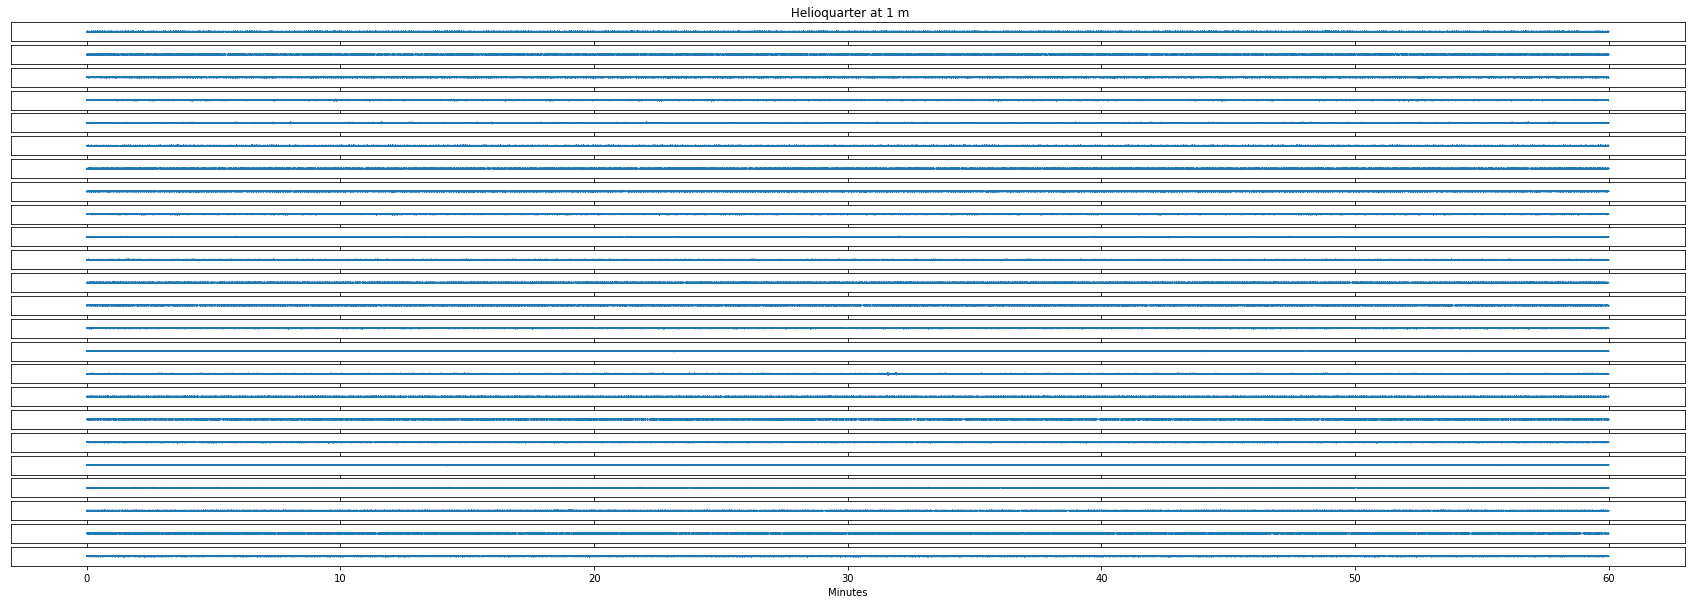

In [28]:
plot_helioquarter(res, 1, '')

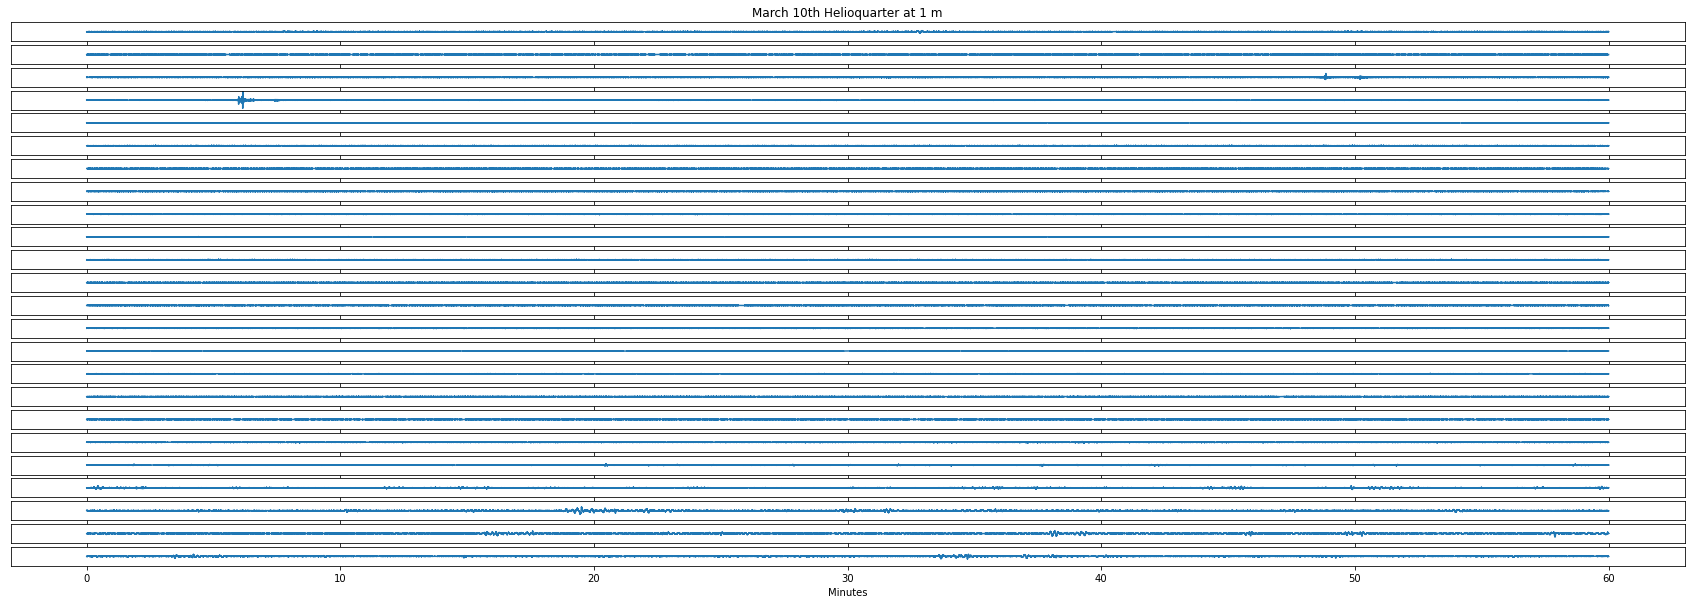

In [12]:
plot_helioquarter(res, 1, 'March 10th')
# remove boxs, 1 Pa scale bar, 

In [26]:
def plot_helioquarter_spectrogram(data_dict, height, date, vmax = 0.000001):
    hour_samps = int(data_dict[height].shape[0]/24)
    res_hourly = data_dict[height].reshape(24, hour_samps)
    f, axes = plt.subplots(24, figsize = (20, 20))
    t = np.linspace(0, 60, res_hourly.shape[1])
    for hour in range(res_hourly.shape[0]):
        ax = axes[hour]
        f, t, Sxx = spectrogram(res_hourly[hour, :], fs = 200)
        t = t / 60
        ax.pcolormesh(t, f, Sxx, shading='gouraud', vmin = 0, vmax = vmax)
        # ax.set_ylim(-2.5, 2.5)
        ax.get_yaxis().set_visible(False)
        if hour == 23:
            ax.set_xlabel('Minutes')
        if hour == 0:
            ax.set_title(f'{date} Spectrogram at {height} m')

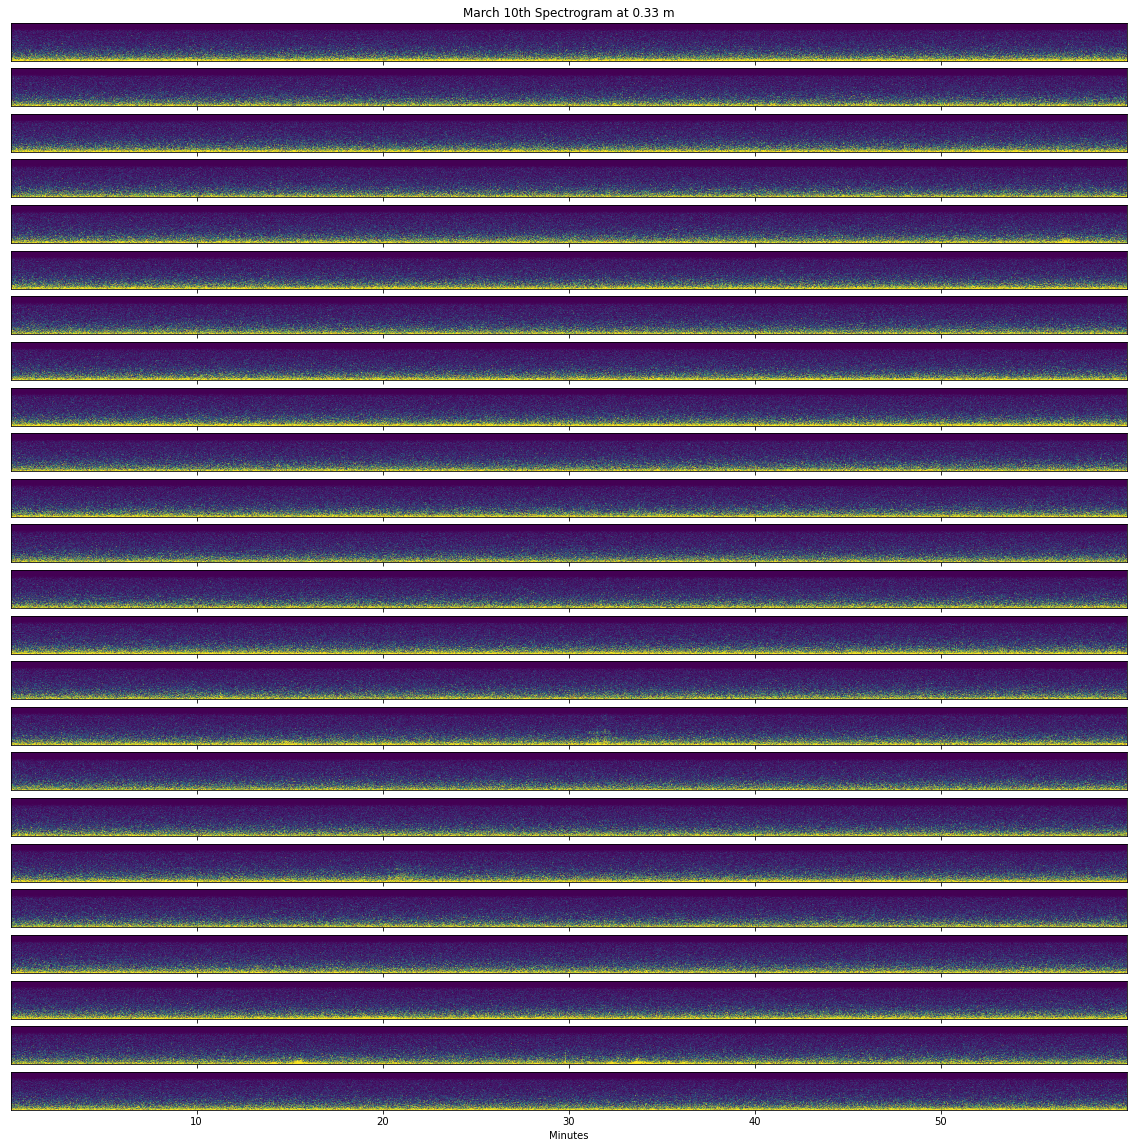

In [27]:
plot_helioquarter_spectrogram(res, 1, 'March 10th')

In [10]:
def correlation_plot(day_list, date, height_1, height_2, wind_len_sec, fc, sps = 200):
    res = get_day(day_list, date)
    res_hourly_1 = high_pass_filter(res[height_1], 2, fc)
    res_hourly_1 = res_hourly_1.reshape(24, -1)
    res_hourly_2 = high_pass_filter(res[height_2], 2, fc)
    res_hourly_2  = res_hourly_2.reshape(24, -1)
    f, axes = plt.subplots(24, figsize = (20, 20))
    for hour in range(res_hourly_1.shape[0]):
        wind = wind_len_sec * sps
        arr1 = np.reshape(res_hourly_1[hour], (int(wind),int(len(res_hourly_1[hour])/wind)), 'F')
        #arr2 = arr2.reshape(-1, int(wind))
        arr2 = np.reshape(res_hourly_2[hour], (int(wind),int(len(res_hourly_2[hour])/wind)), 'F')

        # now compute Pearson
        xcorr0lag = np.sum(arr1*arr2, axis = 0)
        #xcorr0lag = sum(arr1*arr2)
        normalization = np.sqrt(np.sum(arr1**2, axis = 0)*np.sum(arr2**2, axis = 0))
        Pcoeff = xcorr0lag/normalization
        ax = axes[hour]
        t = np.linspace(0, 60, Pcoeff.size)
        ax.plot(t, Pcoeff)
        ax.set_ylim(0,1)
        ax.set_xlim(0,60)
        ax.get_yaxis().set_visible(False)
        if hour == 23:
            ax.set_xlabel('Minutes')
        if hour == 0:
            ax.set_title(f'{date} - Correlation between {height_1} and {height_2} m')

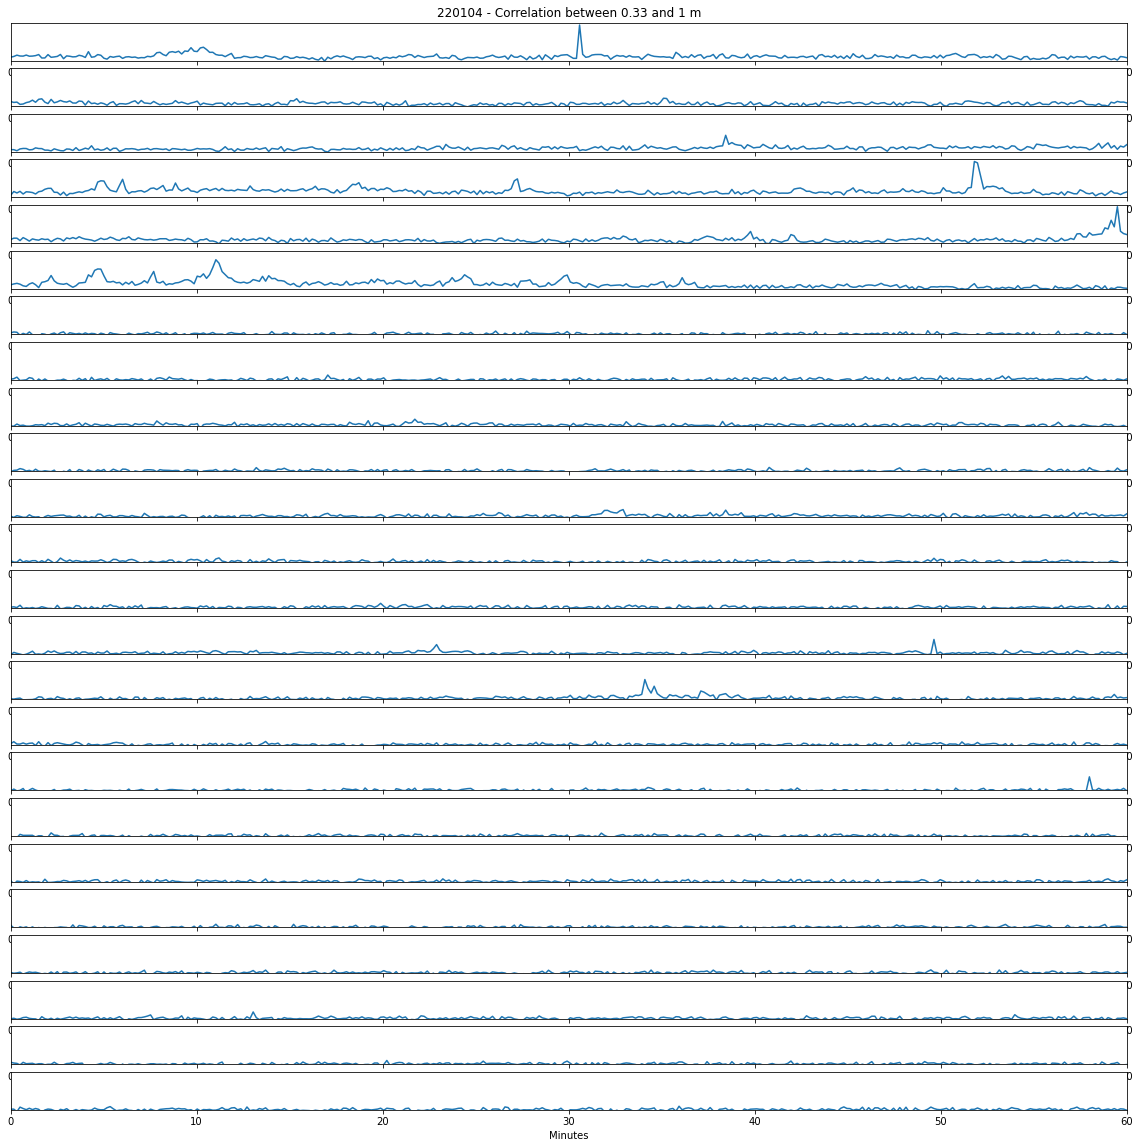

In [16]:
correlation_plot(r, '220104', 0.33, 1, fc = 5, wind_len_sec = 10)

In [17]:
earthquake_time = '18:26:10'
day = res[0.33].reshape(24,-1)

In [18]:
eq_hour = int(earthquake_time.split(':')[0])
hour = day[eq_hour]

In [7]:
def correlation_eq_hour(day_list,eq_day, eq_hour, height_1, height_2, wind_len_sec, fc, sps = 200):
    res = get_day(day_list, eq_day)
    hour_samps = int(res[height_1].shape[0]/24)
    res_hourly_1 = high_pass_filter(res[height_1], 2, fc)
    res_hourly_1 = res_hourly_1.reshape(24, hour_samps)
    res_hourly_2 = high_pass_filter(res[height_2], 2, fc)
    res_hourly_2  = res_hourly_2.reshape(24, hour_samps)
    f, ax = plt.subplots(1, figsize = (10, 5))
    for hour in range(res_hourly_1.shape[0]):
        if hour == eq_hour:
            wind = wind_len_sec * sps
            arr1 = np.reshape(res_hourly_1[hour], (int(wind),int(len(res_hourly_1[hour])/wind)), 'F')
            #arr2 = arr2.reshape(-1, int(wind))
            arr2 = np.reshape(res_hourly_2[hour], (int(wind),int(len(res_hourly_2[hour])/wind)), 'F')

            # now compute Pearson
            xcorr0lag = np.sum(arr1*arr2, axis = 0)
            #xcorr0lag = sum(arr1*arr2)
            normalization = np.sqrt(np.sum(arr1**2, axis = 0)*np.sum(arr2**2, axis = 0))
            Pcoeff = xcorr0lag/normalization
            t = np.linspace(0, 60, Pcoeff.size)
            ax.plot(t, Pcoeff)
            ax.set_ylim(0,1)
            ax.set_xlim(0,60)
            ax.get_yaxis().set_visible(False)
            ax.set_xlabel('Minutes')
            ax.set_title(f'{eq_day} - Correlation between {height_1} and {height_2} m')

# Earthquake Searching

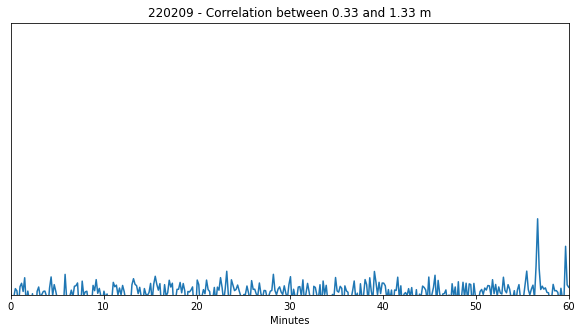

In [8]:
correlation_eq_hour(r, '220209',9, 0.33, 1.33, fc = 5, wind_len_sec = 10)

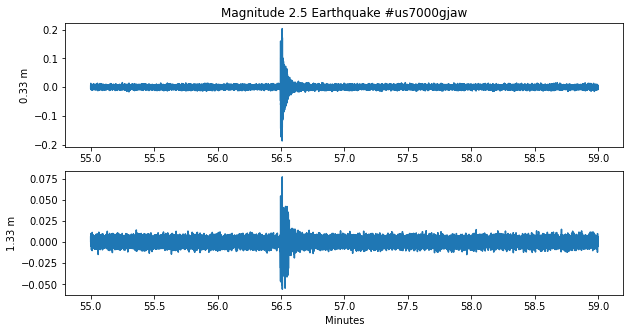

In [22]:
## https://earthquake.usgs.gov/earthquakes/eventpage/us7000gjaw/executive '2022-02-09 @ 09:56:27 - 
show_eq_period(r, '220209', 9, 55, 59, 0.33, 1.33, fc_low = 5, title= 'Magnitude 2.5 Earthquake #us7000gjaw')

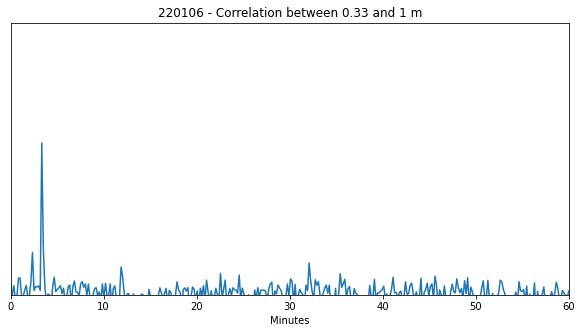

In [10]:
correlation_eq_hour(r, '220106',0, 0.33, 1, fc = 5, wind_len_sec = 10)

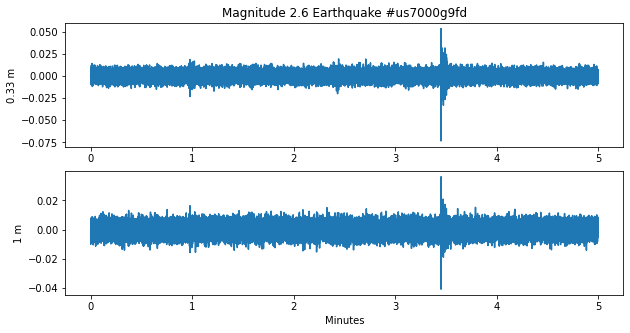

In [24]:
## https://earthquake.usgs.gov/earthquakes/eventpage/us7000g9fd/executive '2022-01-06 @ 00:03:23 - 
show_eq_period(r, '220106', 0, 0, 5, 0.33, 1, fc_low = 5, title= 'Magnitude 2.6 Earthquake #us7000g9fd')

In [6]:
def show_eq_period(day_list,eq_day, eq_hour, start_min, end_min, height_1, height_2, fc_low = 5, fc_high = None, sps = 200, title = None, ylims = None):
    res = get_day(day_list, eq_day)
    if fc_high:
        res_hourly_1 = freq_filt(res[height_1], 2, fc_high, 'low')
        res_hourly_2 = freq_filt(res[height_2], 2, fc_high, 'low')
    if fc_low:
        res_hourly_1 = freq_filt(res[height_1], 2, fc_low, 'high') 
        res_hourly_2 = freq_filt(res[height_2], 2, fc_low, 'high')

    res_hourly_1 = res_hourly_1.reshape(24, -1)
    res_hourly_2  = res_hourly_2.reshape(24, -1)

    f, ax = plt.subplots(2, figsize = (16, 6))

    for hour in range(res_hourly_1.shape[0]):
        if hour == eq_hour:
            start = int(start_min*60*sps)
            end = int(end_min*60*sps)
            arr1 = res_hourly_1[hour][start:end]
            arr2 = res_hourly_2[hour][start:end]
            t = np.linspace(start_min, end_min, arr1.size)
            ax[0].plot(t, arr1)
            ax[1].plot(t, arr2)
            # ax.set_ylim(0,1)
            # ax.set_xlim(0,60)
            # for a in ax:
            #     a.get_yaxis().set_visible(False)
            ax[1].set_xlabel('Minutes')
            if not title:
                ax[0].set_title(f'{eq_day} - Array at {height_1} and {height_2} m')
            else:
                ax[0].set_title(title)
            ax[0].set_ylabel(f'{height_1} m')
            ax[1].set_ylabel(f'{height_2} m')
            if ylims:
                ax[0].set_ylim(ylims)
                ax[1].set_ylim(ylims)

In [95]:
def show_eq_spectrograms(day_list,eq_day, eq_hour, start_min, end_min, height_1, height_2, fc_low = 5, fc_high = None, sps = 200, title = None, vmax = .3, vmin = 0):
    res = get_day(day_list, eq_day)
    if fc_high:
        res_hourly_1 = freq_filt(res[height_1], 2, fc_high, 'low')
        res_hourly_2 = freq_filt(res[height_2], 2, fc_high, 'low')
    if fc_low:
        res_hourly_1 = freq_filt(res[height_1], 2, fc_low, 'high') 
        res_hourly_2 = freq_filt(res[height_2], 2, fc_low, 'high')

    res_hourly_1 = res_hourly_1.reshape(24, -1)
    res_hourly_2  = res_hourly_2.reshape(24, -1)

    f, ax = plt.subplots(2, figsize = (16, 6))

    for hour in range(res_hourly_1.shape[0]):
        if hour == eq_hour:
            start = int(start_min*60*sps)
            end = int(end_min*60*sps)
            arr1 = res_hourly_1[hour][start:end]
            arr2 = res_hourly_2[hour][start:end]
            f, _, Sxx = spectrogram(arr1, fs = sps)
            t = np.linspace(start_min, end_min, Sxx.shape[1])
            ax[0].pcolormesh(t, f, Sxx, shading='gouraud', vmin = vmin, vmax = vmax)
            # ax.set_ylim(-2.5, 2.5)
            # ax[0].get_yaxis().set_visible(False)
            if title:
                ax[0].set_title(title)
            f, _, Sxx = spectrogram(arr2, fs = sps)
            ax[1].pcolormesh(t, f, Sxx, shading='gouraud', vmin = vmin, vmax = vmax)
            # ax.set_ylim(-2.5, 2.5)
            #ax[1].get_yaxis().set_visible(False)
            ax[0].set_ylabel(f'{height_1} m - Hz')
            ax[1].set_ylabel(f'{height_2} m - Hz')
            ax[1].set_xlabel('minutes')
    plt.show()

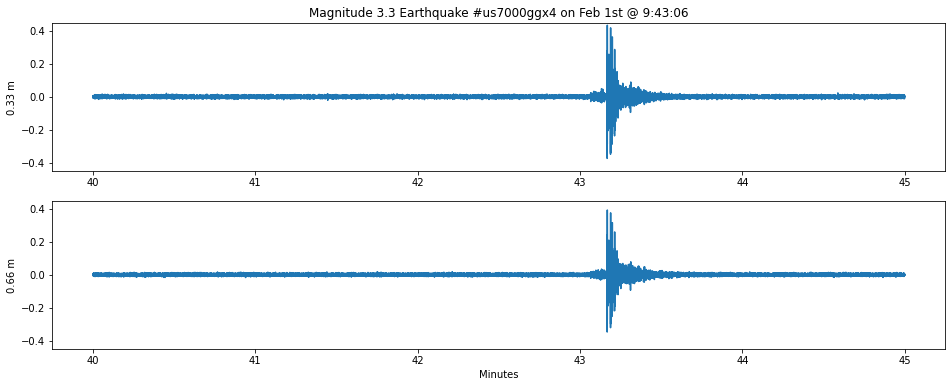

In [9]:
## https://earthquake.usgs.gov/earthquakes/eventpage/us7000ggx4/executive '2022-02-01 @ 09:43:06 - 
show_eq_period(r, '220201', 9, 40, 45, 0.33, 0.66, fc_low = 2, title= 'Magnitude 3.3 Earthquake #us7000ggx4 on Feb 1st @ 9:43:06', ylims=(-0.45,0.45))

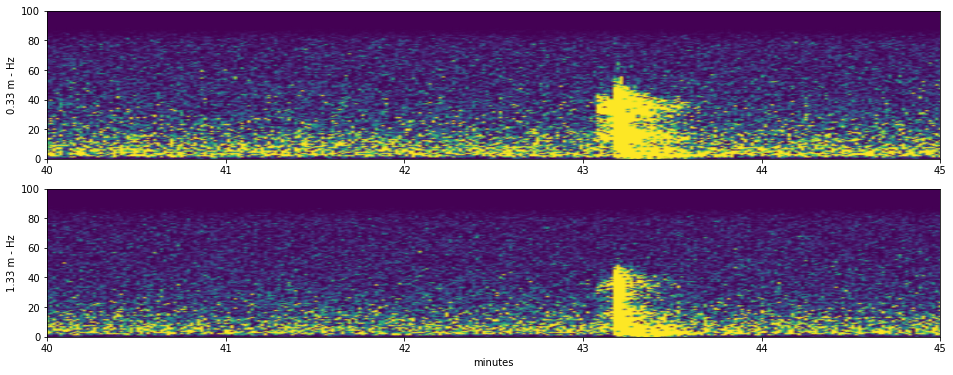

In [73]:
show_eq_spectrograms(r, '220201', 9, 40, 45, 0.33, 1.33, fc_low = 2, vmax = 9e-7, vmin = 1e-10)

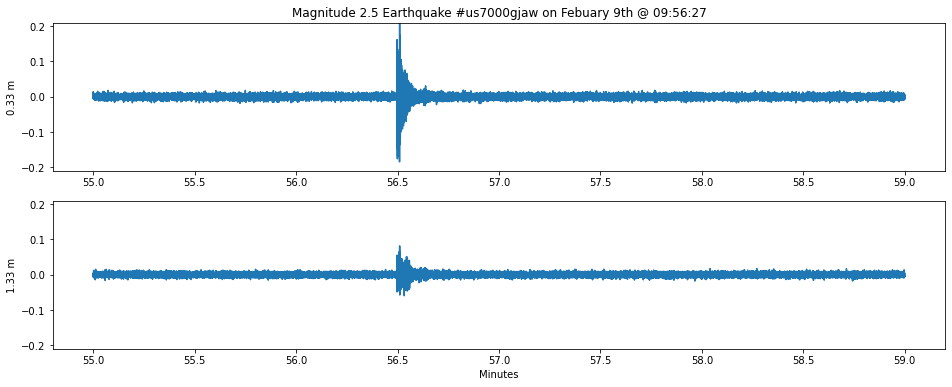

In [92]:
## https://earthquake.usgs.gov/earthquakes/eventpage/us7000gjaw/executive '2022-02-09 @ 09:56:27 - 
show_eq_period(r, '220209', 9, 55, 59, 0.33, 1.33, fc_low = 2, title= 'Magnitude 2.5 Earthquake #us7000gjaw on Febuary 9th @ 09:56:27', ylims = (-0.21,0.21))

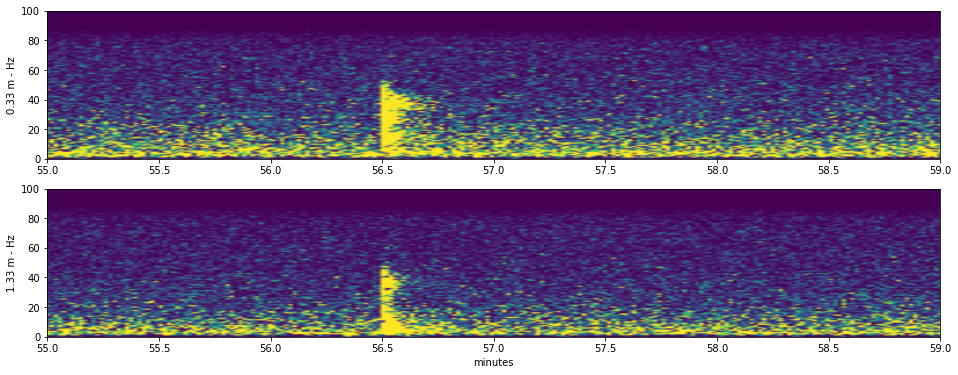

In [96]:
show_eq_spectrograms(r, '220209', 9, 55, 59, 0.33, 1.33, fc_low = 2, vmax = 9e-7, vmin = 1e-10)

# Avalanche Searching

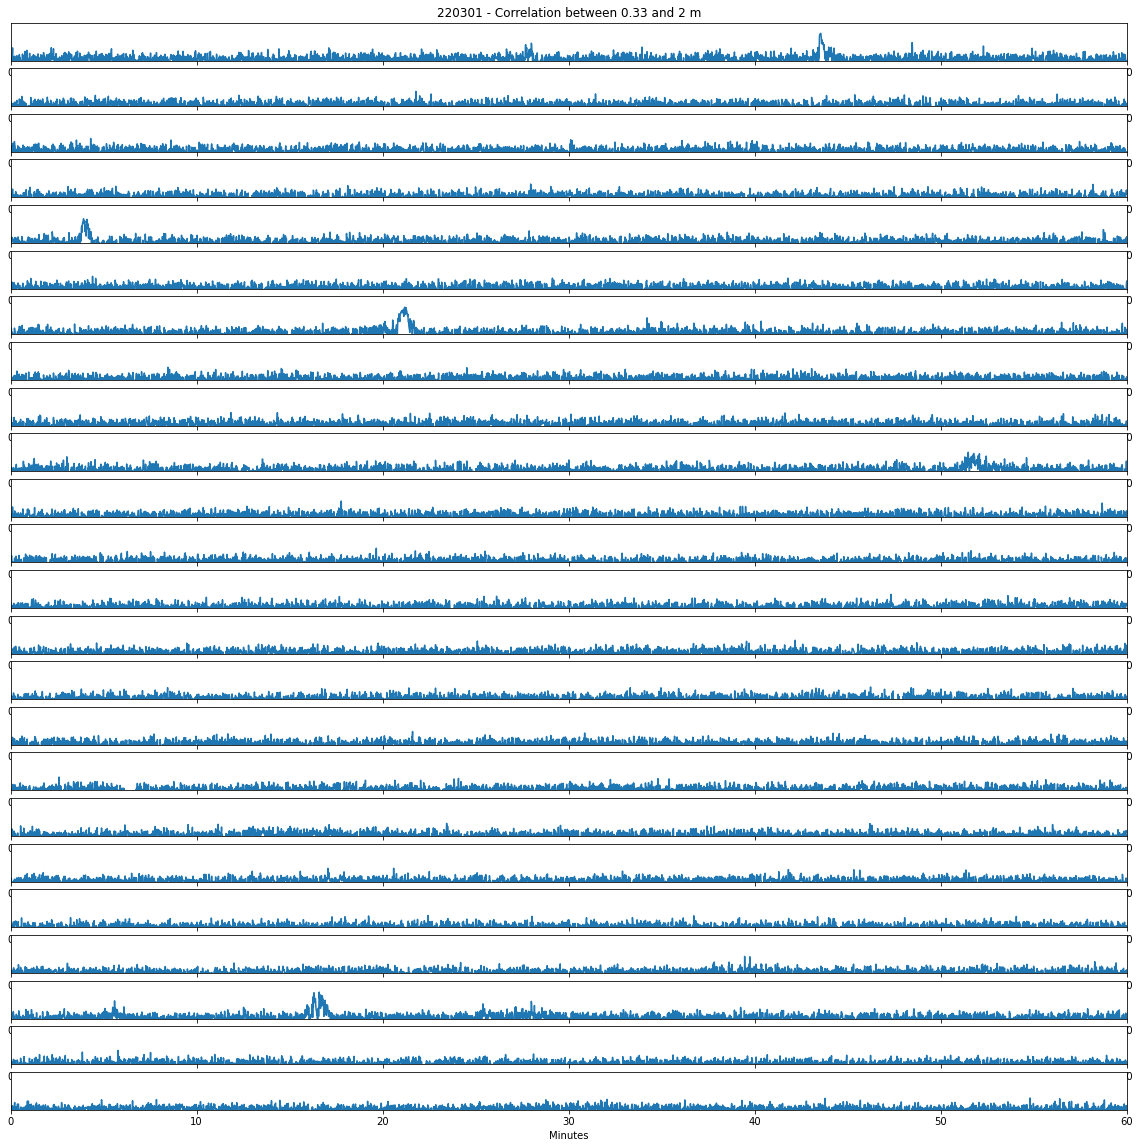

In [39]:
correlation_plot(r, '220301', 0.33, 2, fc = 5, wind_len_sec = 1)

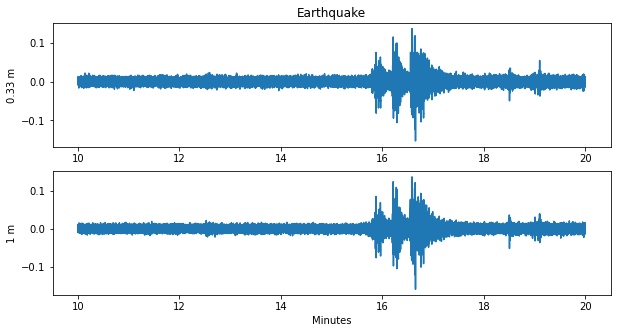

In [42]:
show_eq_period(r, '220301', 21, 10, 20, 0.33, 1, fc_low = 1, title= 'Earthquake')

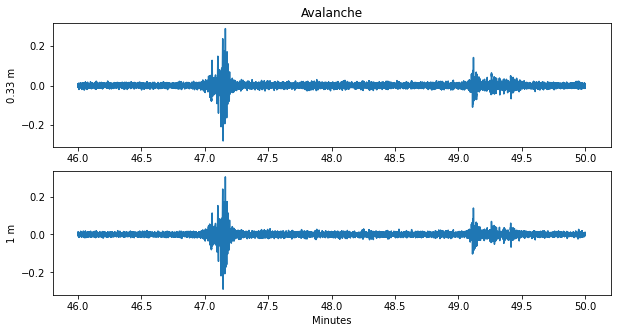

In [27]:
show_eq_period(r, '211227', 22, 46, 50, 0.33, 1, fc_low = 1, title= 'Avalanche')

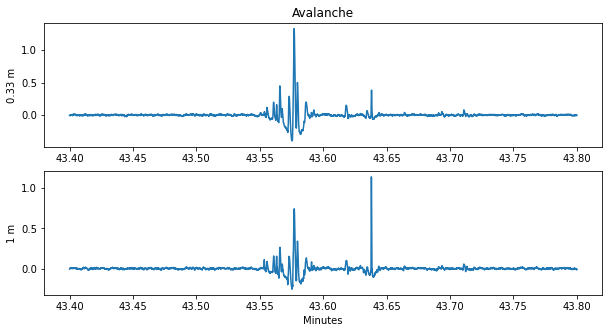

In [28]:
show_eq_period(r, '211227', 21, 43.4, 43.8, 0.33, 1, fc_low = 1, title= 'Avalanche')